In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
pd.set_option('display.max_columns', None)

In [2]:
import analyze_utils

# save_dir =  '/home/jxm3/research/prompting/interpretable-autoprompting/results_icml/classification__prefix_after_input_2/'
# r, all_losses = analyze_utils.load_results_and_cache_autoprompt_json(
#     save_dir, include_losses=True, do_reranking=False, save_file='r.pkl')

import pickle
r = pickle.load(open('../results/classification/r.pkl', 'rb'))

In [3]:
len(r)

30867

In [4]:
pd.set_option('display.max_colwidth', None)

top_prompts = (
    r [r['num_learned_tokens'] < 24] # Drop 24-token runs because some autoprompt runs failed (OOM).
      # .sort_values(by='prefix_train_acc', ascending=False)
      .sort_values(by='prefix_train_loss', ascending=True)
      .groupby(['num_learned_tokens', 'task_name', 'model_cls', 'seed'])
    
).first()
print(len(top_prompts))


top_prompts[['prefixes', 'reciprocal_rank', 'prefix_train_loss', 'prefix_train_acc']]

48


prefixes  \
num_learned_tokens task_name  model_cls  seed                                                                              
6                  ffb_train  autoprompt 1                                                EFFverbal EUR Thorntonshopnown   
                                         2                                             Fur resultolandgroundur augmented   
                                         3                                                      Hackmmmmajoreryitprofits   
                              iprompt    1                                                    almost neutral. However, "   
                                         2                                                              "So, a bottle of   
                                         3                                                 "Does this represent a market   
                   imdb_train autoprompt 1                                             CRIP deserves PIN SOC sling level   
                                         2                                                    as ​Overall': large points   
                                         3                               ™:Supplement Reasons****************RatingUltra   
                              iprompt    1                                                 When you watch and enjoy this   
                                         2                                                      I find this film a total   
                                         3                                                   To summarize this review! :   
                   rt_train   autoprompt 1                                         Whether{{ anotherath<|endoftext|> how   
                                         2                                    congratulations Named #SPONSOREDReport the   
                                         3                                                     wow some oneendered  very   
                              iprompt    1                                                  "not only are the characters   
                                         2                                                    Who is the author of these   
                                         3                                                   Do you agree with the above   
                   sst2_train autoprompt 1                                         \t BryceSpecificallyWASHINGTONRatedam   
                                         2                                                396 trulyCustomer echoes the "   
                                         3                                            ".Too organic appeal "… thoroughly   
                              iprompt    1                                              Can be used to describe anything   
                                         2                                         A statement that expresses a definite   
                                         3                                               Use this sentence to express an   
12                 ffb_train  autoprompt 1                    proportstals"]," AoErisome peas(" Argentina balance WININc   
                                         2                 oil feed UsingOilalyst Albert Herb Grass ling Bankingthe mild   
                                         3          izationalquartersLord quarterTableHeadperiodMON goTEXT Sylcommercial   
                              iprompt    1                                     <input> neutral> The result was due to: "   
                                         2                                A neutral sentence. Should it be: "This is the   
                                         3                                     Neutral? Hmmm. Let's think about this. It   
                   imdb_train autoprompt 1                    Luaagram RomanFaith Rockyux meets Cast Writing Rating and=   
                    

In [94]:
top_prompts.sort_values('prefix_train_acc', ascending=False).reset_index().groupby(['model_cls', 'task_name']).first()['prefixes']

model_cls   task_name 
autoprompt  ffb_train                                       Fur resultolandgroundur augmented
            imdb_train    uclear覚醒cend Koretravel NAACP curses SicAstings production received
            rt_train                                    Whether{{ anotherath<|endoftext|> how
            sst2_train                                     ".Too organic appeal "… thoroughly
iprompt     ffb_train                               <input> neutral> The result was due to: "
            imdb_train                                            'savage'<br /><br />Rating:
            rt_train                 what words would you try to add to help you express that
            sst2_train     It is clear from the sentence that all three actors have something
Name: prefixes, dtype: object

In [5]:
top_prompts.groupby(['task_name', 'model_cls']).mean()['prefix_train_acc']

task_name   model_cls 
ffb_train   autoprompt    0.692708
            iprompt       0.804688
imdb_train  autoprompt    0.888021
            iprompt       0.908854
rt_train    autoprompt    0.781250
            iprompt       0.828125
sst2_train  autoprompt    0.835938
            iprompt       0.869792
Name: prefix_train_acc, dtype: float64

In [20]:
# assert r['checkpoint'].unique()[0] == "EleutherAI/gpt-j-6B"

# from iprompt import prompt_classification

# model = prompt_classification.create_model(r['checkpoint'].unique()[0])

In [ ]:
## Compute accuracy given correct prompt and save for each task.
import argparse
from tqdm.notebook import tqdm
from iprompt.data import get_data


data = []
print('calculating accs...')
n_shots = 1
batch_size = 8

"""
task_name: str = 'add_two',
 n_shots: int = 1,
 train_split_frac: float = None,
 max_dset_size: int = 10000,
 template_num_task_phrasing: int = 0,
 max_digit: int = 10,
 """

for _, output in tqdm(top_prompts.reset_index().iterrows(), total=len(top_prompts)):
    verbose = False
    max_length = 128
    # if not (('ffb' in output['task_name']) or ('imdb' in output['task_name'])): continue
    # if output['model_cls'] == 'autoprompt': continue
    # if 'ffb' in output['task_name']: continue
    if output['num_learned_tokens'] <= 6: continue # skip that eval for now :-)
    output['task_name'] = output['task_name'].replace('_train', '_test')
    args = argparse.Namespace(**output)
    args.train_split_frac = 1.0 # take 100% of test set
    args.max_dset_size = 1_000
    print("*-*-" * 20)
    print(args.task_name)
    (dset, __dset_test), check_answer_func, descr = get_data(
        args.task_name, n_shots=n_shots, train_split_frac=args.train_split_frac,
        max_dset_size=args.max_dset_size, template_num_task_phrasing=0,
    )
    # if task_name == 'task107_splash_question_to_sql':
    #     batch_size = max(1, batch_size//4)
    ####   Manual prompt  ####
    descr = "" # tmp override
    manual_loss, manual_acc = prompt_classification.test_model_on_task_with_prefix(
        dset=dset, model=model, prefix=descr, multi_token=False, verbose=verbose,
        max_length=max_length, batch_size=64, tqdm_notebook=True,
        restrict_to_valid_answers=True,
        prefix_before_input=False,
    )
    # print(output)
    print(f'\t{descr} || {manual_acc:.1f}%')
    ####   iPrompt prompt   ####
    iprompt_loss, iprompt_acc = prompt_classification.test_model_on_task_with_prefix(
        dset=dset, model=model, prefix=output['prefixes'], multi_token=False, verbose=verbose,
        max_length=max_length, batch_size=64, tqdm_notebook=True,
        restrict_to_valid_answers=True,
        prefix_before_input=False,
    )
    print(f'\t{output["prefixes"]} || {iprompt_acc:.1f}%')
    ####
    output['manual_acc'] = manual_acc
    output['iprompt_acc'] = iprompt_acc
    data.append(output)

In [ ]:
df_with_acc = pd.DataFrame(data)
# df_with_acc[['task_name', 'model_cls', 'seed', 'prefixes', 'prefix_train_acc', 'iprompt_acc', 'manual_acc']]
df_with_acc[df_with_acc['num_learned_tokens'] < 24].groupby(['num_learned_tokens', 'task_name', 'model_cls']).mean()[['iprompt_acc', 'manual_acc']]

In [ ]:
final_prompts_df = df_with_acc[df_with_acc['num_learned_tokens'] < 24]
pd.set_option('display.max_rows', None)

final_prompts_df[['num_learned_tokens', 'model_cls', 'task_name', 'prefixes', 'iprompt_acc']]

In [ ]:
final_prompts_df.sort_values('iprompt_acc', ascending=False).first()

In [84]:
final_prompts_df.groupby(['model_cls', 'task_name']).mean()[['iprompt_acc', 'manual_acc']]

iprompt_acc  manual_acc
model_cls  task_name                         
autoprompt ffb_test     56.163636   42.707071
           imdb_test    86.666667   58.600000
           rt_test      73.016667   59.200000
           sst2_test    76.701070   60.894495
iprompt    ffb_test     79.250000   47.500000
           imdb_test    87.916667   58.600000
           rt_test      84.833333   59.200000
           sst2_test    86.716361   60.894495

In [86]:
final_prompts_df.groupby(['model_cls', 'task_name']).sem()[['iprompt_acc', 'manual_acc']]

iprompt_acc  manual_acc
model_cls  task_name                         
autoprompt ffb_test      9.053265    2.443157
           imdb_test     1.204067    0.000000
           rt_test       4.829798    0.000000
           sst2_test     3.901040    0.000000
iprompt    ffb_test      2.028587    0.000000
           imdb_test     1.378506    0.000000
           rt_test       0.829726    0.000000
           sst2_test     0.951405    0.000000

In [69]:
## Promptsource GPT-J Accuracy
from iprompt import prompt_classification
from tqdm.notebook import tqdm
from iprompt.data import get_data

PROMPTSOURCE_PROMPTS = [
    ' The movie review in negative/positive sentiment is:',
    ###############################################################
    ' Does the previous input have a positive or negative sentiment?',
    ' Was that review positive or negative?',
    ' The sentiment expressed for the movie is',
    ' What is the sentiment expressed by the reviewer for the movie?',
    ' How does the viewer feel about the movie?',
    ' Is this review positive or negative?',
    ' What is the sentiment expressed in this text?',
    ' What sentiment does the writer express for the movie?',
]

# Financial phrasebank has a neutral class
PROMPTSOURCE_PROMPTS_NEUTRAL = [
    ' Does the previous input have a positive, neutral, or negative sentiment?',
    ' Was that input positive, neutral, or negative?',
    ' The sentiment expressed in the headline is',
    ' What is the sentiment expressed by the reviewer for the movie?',
    ' How does the author of the news headline feel?',
    ' Is this news headline positive, neutral, or negative?',
    ' What is the sentiment expressed in this text?',
    ' What sentiment does the writer express?',
]


prompt_data = []
task_names = r.reset_index()['task_name'].unique().tolist()
for task_name in tqdm(task_names):
    verbose = False
    max_length = 128
    prompts = PROMPTSOURCE_PROMPTS_NEUTRAL if ('ffb' in task_name) else PROMPTSOURCE_PROMPTS
    for _idx, _prompt in enumerate(prompts):
        output = {}
        output['task_name'] = task_name.replace('_train', '_test')
        train_split_frac = 1.0 # take 100% of test set
        max_dset_size = 1_000
        (dset, __dset_test), check_answer_func, descr = get_data(
            output['task_name'], n_shots=1, train_split_frac=1.0,
            max_dset_size=max_dset_size, template_num_task_phrasing=0,
        )
    #     ####   human-written prompt   ####
        loss, acc = prompt_classification.test_model_on_task_with_prefix(
            dset=dset, model=model, prefix=_prompt, multi_token=False, verbose=verbose,
            max_length=max_length, batch_size=64, tqdm_notebook=True,
            restrict_to_valid_answers=True,
            prefix_before_input=False,
        )
        print(f'\t{_prompt} || {acc:.1f}%')
        ####
        output['prompt_idx'] = _idx
        output['acc'] = acc
        prompt_data.append(output)

  0%|          | 0/4 [00:00<?, ?it/s]

**loading data: sst2 // validation


Found cached dataset sst2 (/home/jxm3/.cache/huggingface/datasets/sst2/default/2.0.0/9896208a8d85db057ac50c72282bcb8fe755accc671a57dd8059d4e130961ed5)
Loading cached shuffled indices for dataset at /home/jxm3/.cache/huggingface/datasets/sst2/default/2.0.0/9896208a8d85db057ac50c72282bcb8fe755accc671a57dd8059d4e130961ed5/cache-48129d1559bb651f.arrow
Loading cached processed dataset at /home/jxm3/.cache/huggingface/datasets/sst2/default/2.0.0/9896208a8d85db057ac50c72282bcb8fe755accc671a57dd8059d4e130961ed5/cache-93efb9f1d3e163f8.arrow
Loading cached processed dataset at /home/jxm3/.cache/huggingface/datasets/sst2/default/2.0.0/9896208a8d85db057ac50c72282bcb8fe755accc671a57dd8059d4e130961ed5/cache-e504b88d092263aa.arrow


no_quotes = True


  0%|          | 0/14 [00:00<?, ?it/s]

	 The movie review in negative/positive sentiment is: || 58.7%
**loading data: sst2 // validation


Found cached dataset sst2 (/home/jxm3/.cache/huggingface/datasets/sst2/default/2.0.0/9896208a8d85db057ac50c72282bcb8fe755accc671a57dd8059d4e130961ed5)
Loading cached shuffled indices for dataset at /home/jxm3/.cache/huggingface/datasets/sst2/default/2.0.0/9896208a8d85db057ac50c72282bcb8fe755accc671a57dd8059d4e130961ed5/cache-48129d1559bb651f.arrow
Loading cached processed dataset at /home/jxm3/.cache/huggingface/datasets/sst2/default/2.0.0/9896208a8d85db057ac50c72282bcb8fe755accc671a57dd8059d4e130961ed5/cache-93efb9f1d3e163f8.arrow
Loading cached processed dataset at /home/jxm3/.cache/huggingface/datasets/sst2/default/2.0.0/9896208a8d85db057ac50c72282bcb8fe755accc671a57dd8059d4e130961ed5/cache-e504b88d092263aa.arrow


no_quotes = True


  0%|          | 0/14 [00:00<?, ?it/s]

	 Does the previous input have a positive or negative sentiment? || 49.5%
**loading data: sst2 // validation


Found cached dataset sst2 (/home/jxm3/.cache/huggingface/datasets/sst2/default/2.0.0/9896208a8d85db057ac50c72282bcb8fe755accc671a57dd8059d4e130961ed5)
Loading cached shuffled indices for dataset at /home/jxm3/.cache/huggingface/datasets/sst2/default/2.0.0/9896208a8d85db057ac50c72282bcb8fe755accc671a57dd8059d4e130961ed5/cache-48129d1559bb651f.arrow
Loading cached processed dataset at /home/jxm3/.cache/huggingface/datasets/sst2/default/2.0.0/9896208a8d85db057ac50c72282bcb8fe755accc671a57dd8059d4e130961ed5/cache-93efb9f1d3e163f8.arrow
Loading cached processed dataset at /home/jxm3/.cache/huggingface/datasets/sst2/default/2.0.0/9896208a8d85db057ac50c72282bcb8fe755accc671a57dd8059d4e130961ed5/cache-e504b88d092263aa.arrow


no_quotes = True


  0%|          | 0/14 [00:00<?, ?it/s]

	 Was that review positive or negative? || 53.9%
**loading data: sst2 // validation


Found cached dataset sst2 (/home/jxm3/.cache/huggingface/datasets/sst2/default/2.0.0/9896208a8d85db057ac50c72282bcb8fe755accc671a57dd8059d4e130961ed5)
Loading cached shuffled indices for dataset at /home/jxm3/.cache/huggingface/datasets/sst2/default/2.0.0/9896208a8d85db057ac50c72282bcb8fe755accc671a57dd8059d4e130961ed5/cache-48129d1559bb651f.arrow
Loading cached processed dataset at /home/jxm3/.cache/huggingface/datasets/sst2/default/2.0.0/9896208a8d85db057ac50c72282bcb8fe755accc671a57dd8059d4e130961ed5/cache-93efb9f1d3e163f8.arrow
Loading cached processed dataset at /home/jxm3/.cache/huggingface/datasets/sst2/default/2.0.0/9896208a8d85db057ac50c72282bcb8fe755accc671a57dd8059d4e130961ed5/cache-e504b88d092263aa.arrow


no_quotes = True


  0%|          | 0/14 [00:00<?, ?it/s]

	 The sentiment expressed for the movie is || 50.9%
**loading data: sst2 // validation


Found cached dataset sst2 (/home/jxm3/.cache/huggingface/datasets/sst2/default/2.0.0/9896208a8d85db057ac50c72282bcb8fe755accc671a57dd8059d4e130961ed5)
Loading cached shuffled indices for dataset at /home/jxm3/.cache/huggingface/datasets/sst2/default/2.0.0/9896208a8d85db057ac50c72282bcb8fe755accc671a57dd8059d4e130961ed5/cache-48129d1559bb651f.arrow
Loading cached processed dataset at /home/jxm3/.cache/huggingface/datasets/sst2/default/2.0.0/9896208a8d85db057ac50c72282bcb8fe755accc671a57dd8059d4e130961ed5/cache-93efb9f1d3e163f8.arrow
Loading cached processed dataset at /home/jxm3/.cache/huggingface/datasets/sst2/default/2.0.0/9896208a8d85db057ac50c72282bcb8fe755accc671a57dd8059d4e130961ed5/cache-e504b88d092263aa.arrow


no_quotes = True


  0%|          | 0/14 [00:00<?, ?it/s]

	 What is the sentiment expressed by the reviewer for the movie? || 71.0%
**loading data: sst2 // validation


Found cached dataset sst2 (/home/jxm3/.cache/huggingface/datasets/sst2/default/2.0.0/9896208a8d85db057ac50c72282bcb8fe755accc671a57dd8059d4e130961ed5)
Loading cached shuffled indices for dataset at /home/jxm3/.cache/huggingface/datasets/sst2/default/2.0.0/9896208a8d85db057ac50c72282bcb8fe755accc671a57dd8059d4e130961ed5/cache-48129d1559bb651f.arrow
Loading cached processed dataset at /home/jxm3/.cache/huggingface/datasets/sst2/default/2.0.0/9896208a8d85db057ac50c72282bcb8fe755accc671a57dd8059d4e130961ed5/cache-93efb9f1d3e163f8.arrow
Loading cached processed dataset at /home/jxm3/.cache/huggingface/datasets/sst2/default/2.0.0/9896208a8d85db057ac50c72282bcb8fe755accc671a57dd8059d4e130961ed5/cache-e504b88d092263aa.arrow


no_quotes = True


  0%|          | 0/14 [00:00<?, ?it/s]

	 How does the viewer feel about the movie? || 65.6%
**loading data: sst2 // validation


Found cached dataset sst2 (/home/jxm3/.cache/huggingface/datasets/sst2/default/2.0.0/9896208a8d85db057ac50c72282bcb8fe755accc671a57dd8059d4e130961ed5)
Loading cached shuffled indices for dataset at /home/jxm3/.cache/huggingface/datasets/sst2/default/2.0.0/9896208a8d85db057ac50c72282bcb8fe755accc671a57dd8059d4e130961ed5/cache-48129d1559bb651f.arrow
Loading cached processed dataset at /home/jxm3/.cache/huggingface/datasets/sst2/default/2.0.0/9896208a8d85db057ac50c72282bcb8fe755accc671a57dd8059d4e130961ed5/cache-93efb9f1d3e163f8.arrow
Loading cached processed dataset at /home/jxm3/.cache/huggingface/datasets/sst2/default/2.0.0/9896208a8d85db057ac50c72282bcb8fe755accc671a57dd8059d4e130961ed5/cache-e504b88d092263aa.arrow


no_quotes = True


  0%|          | 0/14 [00:00<?, ?it/s]

	 Is this review positive or negative? || 53.7%
**loading data: sst2 // validation


Found cached dataset sst2 (/home/jxm3/.cache/huggingface/datasets/sst2/default/2.0.0/9896208a8d85db057ac50c72282bcb8fe755accc671a57dd8059d4e130961ed5)
Loading cached shuffled indices for dataset at /home/jxm3/.cache/huggingface/datasets/sst2/default/2.0.0/9896208a8d85db057ac50c72282bcb8fe755accc671a57dd8059d4e130961ed5/cache-48129d1559bb651f.arrow
Loading cached processed dataset at /home/jxm3/.cache/huggingface/datasets/sst2/default/2.0.0/9896208a8d85db057ac50c72282bcb8fe755accc671a57dd8059d4e130961ed5/cache-93efb9f1d3e163f8.arrow
Loading cached processed dataset at /home/jxm3/.cache/huggingface/datasets/sst2/default/2.0.0/9896208a8d85db057ac50c72282bcb8fe755accc671a57dd8059d4e130961ed5/cache-e504b88d092263aa.arrow


no_quotes = True


  0%|          | 0/14 [00:00<?, ?it/s]

	 What is the sentiment expressed in this text? || 52.8%
**loading data: sst2 // validation


Found cached dataset sst2 (/home/jxm3/.cache/huggingface/datasets/sst2/default/2.0.0/9896208a8d85db057ac50c72282bcb8fe755accc671a57dd8059d4e130961ed5)
Loading cached shuffled indices for dataset at /home/jxm3/.cache/huggingface/datasets/sst2/default/2.0.0/9896208a8d85db057ac50c72282bcb8fe755accc671a57dd8059d4e130961ed5/cache-48129d1559bb651f.arrow
Loading cached processed dataset at /home/jxm3/.cache/huggingface/datasets/sst2/default/2.0.0/9896208a8d85db057ac50c72282bcb8fe755accc671a57dd8059d4e130961ed5/cache-93efb9f1d3e163f8.arrow
Loading cached processed dataset at /home/jxm3/.cache/huggingface/datasets/sst2/default/2.0.0/9896208a8d85db057ac50c72282bcb8fe755accc671a57dd8059d4e130961ed5/cache-e504b88d092263aa.arrow


no_quotes = True


  0%|          | 0/14 [00:00<?, ?it/s]

	 What sentiment does the writer express for the movie? || 69.7%
**loading data: imdb // test


Found cached dataset imdb (/home/jxm3/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1)
Loading cached shuffled indices for dataset at /home/jxm3/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1/cache-903cc9bdd9c6cd62.arrow
Loading cached processed dataset at /home/jxm3/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1/cache-f0ff776056509981.arrow


no_quotes = True


  0%|          | 0/25000 [00:00<?, ?ex/s]

  0%|          | 0/16 [00:00<?, ?it/s]

	 The movie review in negative/positive sentiment is: || 80.6%
**loading data: imdb // test


Found cached dataset imdb (/home/jxm3/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1)
Loading cached shuffled indices for dataset at /home/jxm3/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1/cache-903cc9bdd9c6cd62.arrow
Loading cached processed dataset at /home/jxm3/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1/cache-f0ff776056509981.arrow
Loading cached processed dataset at /home/jxm3/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1/cache-5fda7ea5c7576317.arrow


no_quotes = True


  0%|          | 0/16 [00:00<?, ?it/s]

	 Does the previous input have a positive or negative sentiment? || 62.1%
**loading data: imdb // test


Found cached dataset imdb (/home/jxm3/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1)
Loading cached shuffled indices for dataset at /home/jxm3/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1/cache-903cc9bdd9c6cd62.arrow
Loading cached processed dataset at /home/jxm3/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1/cache-f0ff776056509981.arrow
Loading cached processed dataset at /home/jxm3/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1/cache-5fda7ea5c7576317.arrow


no_quotes = True


  0%|          | 0/16 [00:00<?, ?it/s]

	 Was that review positive or negative? || 56.4%
**loading data: imdb // test


Found cached dataset imdb (/home/jxm3/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1)
Loading cached shuffled indices for dataset at /home/jxm3/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1/cache-903cc9bdd9c6cd62.arrow
Loading cached processed dataset at /home/jxm3/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1/cache-f0ff776056509981.arrow
Loading cached processed dataset at /home/jxm3/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1/cache-5fda7ea5c7576317.arrow


no_quotes = True


  0%|          | 0/16 [00:00<?, ?it/s]

	 The sentiment expressed for the movie is || 53.1%
**loading data: imdb // test


Found cached dataset imdb (/home/jxm3/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1)
Loading cached shuffled indices for dataset at /home/jxm3/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1/cache-903cc9bdd9c6cd62.arrow
Loading cached processed dataset at /home/jxm3/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1/cache-f0ff776056509981.arrow
Loading cached processed dataset at /home/jxm3/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1/cache-5fda7ea5c7576317.arrow


no_quotes = True


  0%|          | 0/16 [00:00<?, ?it/s]

	 What is the sentiment expressed by the reviewer for the movie? || 61.5%
**loading data: imdb // test


Found cached dataset imdb (/home/jxm3/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1)
Loading cached shuffled indices for dataset at /home/jxm3/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1/cache-903cc9bdd9c6cd62.arrow
Loading cached processed dataset at /home/jxm3/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1/cache-f0ff776056509981.arrow
Loading cached processed dataset at /home/jxm3/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1/cache-5fda7ea5c7576317.arrow


no_quotes = True


  0%|          | 0/16 [00:00<?, ?it/s]

	 How does the viewer feel about the movie? || 76.5%
**loading data: imdb // test


Found cached dataset imdb (/home/jxm3/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1)
Loading cached shuffled indices for dataset at /home/jxm3/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1/cache-903cc9bdd9c6cd62.arrow
Loading cached processed dataset at /home/jxm3/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1/cache-f0ff776056509981.arrow
Loading cached processed dataset at /home/jxm3/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1/cache-5fda7ea5c7576317.arrow


no_quotes = True


  0%|          | 0/16 [00:00<?, ?it/s]

	 Is this review positive or negative? || 60.9%
**loading data: imdb // test


Found cached dataset imdb (/home/jxm3/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1)
Loading cached shuffled indices for dataset at /home/jxm3/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1/cache-903cc9bdd9c6cd62.arrow
Loading cached processed dataset at /home/jxm3/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1/cache-f0ff776056509981.arrow
Loading cached processed dataset at /home/jxm3/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1/cache-5fda7ea5c7576317.arrow


no_quotes = True


  0%|          | 0/16 [00:00<?, ?it/s]

	 What is the sentiment expressed in this text? || 67.2%
**loading data: imdb // test


Found cached dataset imdb (/home/jxm3/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1)
Loading cached shuffled indices for dataset at /home/jxm3/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1/cache-903cc9bdd9c6cd62.arrow
Loading cached processed dataset at /home/jxm3/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1/cache-f0ff776056509981.arrow
Loading cached processed dataset at /home/jxm3/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1/cache-5fda7ea5c7576317.arrow


no_quotes = True


  0%|          | 0/16 [00:00<?, ?it/s]

	 What sentiment does the writer express for the movie? || 75.9%
**loading data: rotten_tomatoes // test


Found cached dataset rotten_tomatoes (/home/jxm3/.cache/huggingface/datasets/rotten_tomatoes/default/1.0.0/40d411e45a6ce3484deed7cc15b82a53dad9a72aafd9f86f8f227134bec5ca46)
Loading cached shuffled indices for dataset at /home/jxm3/.cache/huggingface/datasets/rotten_tomatoes/default/1.0.0/40d411e45a6ce3484deed7cc15b82a53dad9a72aafd9f86f8f227134bec5ca46/cache-77da4abfd6ddcc0f.arrow
Loading cached processed dataset at /home/jxm3/.cache/huggingface/datasets/rotten_tomatoes/default/1.0.0/40d411e45a6ce3484deed7cc15b82a53dad9a72aafd9f86f8f227134bec5ca46/cache-6f5cb5a93d30a201.arrow


no_quotes = True


  0%|          | 0/1066 [00:00<?, ?ex/s]

  0%|          | 0/16 [00:00<?, ?it/s]

	 The movie review in negative/positive sentiment is: || 60.2%
**loading data: rotten_tomatoes // test


Found cached dataset rotten_tomatoes (/home/jxm3/.cache/huggingface/datasets/rotten_tomatoes/default/1.0.0/40d411e45a6ce3484deed7cc15b82a53dad9a72aafd9f86f8f227134bec5ca46)
Loading cached shuffled indices for dataset at /home/jxm3/.cache/huggingface/datasets/rotten_tomatoes/default/1.0.0/40d411e45a6ce3484deed7cc15b82a53dad9a72aafd9f86f8f227134bec5ca46/cache-77da4abfd6ddcc0f.arrow
Loading cached processed dataset at /home/jxm3/.cache/huggingface/datasets/rotten_tomatoes/default/1.0.0/40d411e45a6ce3484deed7cc15b82a53dad9a72aafd9f86f8f227134bec5ca46/cache-6f5cb5a93d30a201.arrow
Loading cached processed dataset at /home/jxm3/.cache/huggingface/datasets/rotten_tomatoes/default/1.0.0/40d411e45a6ce3484deed7cc15b82a53dad9a72aafd9f86f8f227134bec5ca46/cache-e65e0a5964d6a8e6.arrow


no_quotes = True


  0%|          | 0/16 [00:00<?, ?it/s]

	 Does the previous input have a positive or negative sentiment? || 50.5%
**loading data: rotten_tomatoes // test


Found cached dataset rotten_tomatoes (/home/jxm3/.cache/huggingface/datasets/rotten_tomatoes/default/1.0.0/40d411e45a6ce3484deed7cc15b82a53dad9a72aafd9f86f8f227134bec5ca46)
Loading cached shuffled indices for dataset at /home/jxm3/.cache/huggingface/datasets/rotten_tomatoes/default/1.0.0/40d411e45a6ce3484deed7cc15b82a53dad9a72aafd9f86f8f227134bec5ca46/cache-77da4abfd6ddcc0f.arrow
Loading cached processed dataset at /home/jxm3/.cache/huggingface/datasets/rotten_tomatoes/default/1.0.0/40d411e45a6ce3484deed7cc15b82a53dad9a72aafd9f86f8f227134bec5ca46/cache-6f5cb5a93d30a201.arrow
Loading cached processed dataset at /home/jxm3/.cache/huggingface/datasets/rotten_tomatoes/default/1.0.0/40d411e45a6ce3484deed7cc15b82a53dad9a72aafd9f86f8f227134bec5ca46/cache-e65e0a5964d6a8e6.arrow


no_quotes = True


  0%|          | 0/16 [00:00<?, ?it/s]

	 Was that review positive or negative? || 55.4%
**loading data: rotten_tomatoes // test


Found cached dataset rotten_tomatoes (/home/jxm3/.cache/huggingface/datasets/rotten_tomatoes/default/1.0.0/40d411e45a6ce3484deed7cc15b82a53dad9a72aafd9f86f8f227134bec5ca46)
Loading cached shuffled indices for dataset at /home/jxm3/.cache/huggingface/datasets/rotten_tomatoes/default/1.0.0/40d411e45a6ce3484deed7cc15b82a53dad9a72aafd9f86f8f227134bec5ca46/cache-77da4abfd6ddcc0f.arrow
Loading cached processed dataset at /home/jxm3/.cache/huggingface/datasets/rotten_tomatoes/default/1.0.0/40d411e45a6ce3484deed7cc15b82a53dad9a72aafd9f86f8f227134bec5ca46/cache-6f5cb5a93d30a201.arrow
Loading cached processed dataset at /home/jxm3/.cache/huggingface/datasets/rotten_tomatoes/default/1.0.0/40d411e45a6ce3484deed7cc15b82a53dad9a72aafd9f86f8f227134bec5ca46/cache-e65e0a5964d6a8e6.arrow


no_quotes = True


  0%|          | 0/16 [00:00<?, ?it/s]

	 The sentiment expressed for the movie is || 49.9%
**loading data: rotten_tomatoes // test


Found cached dataset rotten_tomatoes (/home/jxm3/.cache/huggingface/datasets/rotten_tomatoes/default/1.0.0/40d411e45a6ce3484deed7cc15b82a53dad9a72aafd9f86f8f227134bec5ca46)
Loading cached shuffled indices for dataset at /home/jxm3/.cache/huggingface/datasets/rotten_tomatoes/default/1.0.0/40d411e45a6ce3484deed7cc15b82a53dad9a72aafd9f86f8f227134bec5ca46/cache-77da4abfd6ddcc0f.arrow
Loading cached processed dataset at /home/jxm3/.cache/huggingface/datasets/rotten_tomatoes/default/1.0.0/40d411e45a6ce3484deed7cc15b82a53dad9a72aafd9f86f8f227134bec5ca46/cache-6f5cb5a93d30a201.arrow
Loading cached processed dataset at /home/jxm3/.cache/huggingface/datasets/rotten_tomatoes/default/1.0.0/40d411e45a6ce3484deed7cc15b82a53dad9a72aafd9f86f8f227134bec5ca46/cache-e65e0a5964d6a8e6.arrow


no_quotes = True


  0%|          | 0/16 [00:00<?, ?it/s]

	 What is the sentiment expressed by the reviewer for the movie? || 71.8%
**loading data: rotten_tomatoes // test


Found cached dataset rotten_tomatoes (/home/jxm3/.cache/huggingface/datasets/rotten_tomatoes/default/1.0.0/40d411e45a6ce3484deed7cc15b82a53dad9a72aafd9f86f8f227134bec5ca46)
Loading cached shuffled indices for dataset at /home/jxm3/.cache/huggingface/datasets/rotten_tomatoes/default/1.0.0/40d411e45a6ce3484deed7cc15b82a53dad9a72aafd9f86f8f227134bec5ca46/cache-77da4abfd6ddcc0f.arrow
Loading cached processed dataset at /home/jxm3/.cache/huggingface/datasets/rotten_tomatoes/default/1.0.0/40d411e45a6ce3484deed7cc15b82a53dad9a72aafd9f86f8f227134bec5ca46/cache-6f5cb5a93d30a201.arrow
Loading cached processed dataset at /home/jxm3/.cache/huggingface/datasets/rotten_tomatoes/default/1.0.0/40d411e45a6ce3484deed7cc15b82a53dad9a72aafd9f86f8f227134bec5ca46/cache-e65e0a5964d6a8e6.arrow


no_quotes = True


  0%|          | 0/16 [00:00<?, ?it/s]

	 How does the viewer feel about the movie? || 64.2%
**loading data: rotten_tomatoes // test


Found cached dataset rotten_tomatoes (/home/jxm3/.cache/huggingface/datasets/rotten_tomatoes/default/1.0.0/40d411e45a6ce3484deed7cc15b82a53dad9a72aafd9f86f8f227134bec5ca46)
Loading cached shuffled indices for dataset at /home/jxm3/.cache/huggingface/datasets/rotten_tomatoes/default/1.0.0/40d411e45a6ce3484deed7cc15b82a53dad9a72aafd9f86f8f227134bec5ca46/cache-77da4abfd6ddcc0f.arrow
Loading cached processed dataset at /home/jxm3/.cache/huggingface/datasets/rotten_tomatoes/default/1.0.0/40d411e45a6ce3484deed7cc15b82a53dad9a72aafd9f86f8f227134bec5ca46/cache-6f5cb5a93d30a201.arrow
Loading cached processed dataset at /home/jxm3/.cache/huggingface/datasets/rotten_tomatoes/default/1.0.0/40d411e45a6ce3484deed7cc15b82a53dad9a72aafd9f86f8f227134bec5ca46/cache-e65e0a5964d6a8e6.arrow


no_quotes = True


  0%|          | 0/16 [00:00<?, ?it/s]

	 Is this review positive or negative? || 52.3%
**loading data: rotten_tomatoes // test


Found cached dataset rotten_tomatoes (/home/jxm3/.cache/huggingface/datasets/rotten_tomatoes/default/1.0.0/40d411e45a6ce3484deed7cc15b82a53dad9a72aafd9f86f8f227134bec5ca46)
Loading cached shuffled indices for dataset at /home/jxm3/.cache/huggingface/datasets/rotten_tomatoes/default/1.0.0/40d411e45a6ce3484deed7cc15b82a53dad9a72aafd9f86f8f227134bec5ca46/cache-77da4abfd6ddcc0f.arrow
Loading cached processed dataset at /home/jxm3/.cache/huggingface/datasets/rotten_tomatoes/default/1.0.0/40d411e45a6ce3484deed7cc15b82a53dad9a72aafd9f86f8f227134bec5ca46/cache-6f5cb5a93d30a201.arrow
Loading cached processed dataset at /home/jxm3/.cache/huggingface/datasets/rotten_tomatoes/default/1.0.0/40d411e45a6ce3484deed7cc15b82a53dad9a72aafd9f86f8f227134bec5ca46/cache-e65e0a5964d6a8e6.arrow


no_quotes = True


  0%|          | 0/16 [00:00<?, ?it/s]

	 What is the sentiment expressed in this text? || 51.7%
**loading data: rotten_tomatoes // test


Found cached dataset rotten_tomatoes (/home/jxm3/.cache/huggingface/datasets/rotten_tomatoes/default/1.0.0/40d411e45a6ce3484deed7cc15b82a53dad9a72aafd9f86f8f227134bec5ca46)
Loading cached shuffled indices for dataset at /home/jxm3/.cache/huggingface/datasets/rotten_tomatoes/default/1.0.0/40d411e45a6ce3484deed7cc15b82a53dad9a72aafd9f86f8f227134bec5ca46/cache-77da4abfd6ddcc0f.arrow
Loading cached processed dataset at /home/jxm3/.cache/huggingface/datasets/rotten_tomatoes/default/1.0.0/40d411e45a6ce3484deed7cc15b82a53dad9a72aafd9f86f8f227134bec5ca46/cache-6f5cb5a93d30a201.arrow
Loading cached processed dataset at /home/jxm3/.cache/huggingface/datasets/rotten_tomatoes/default/1.0.0/40d411e45a6ce3484deed7cc15b82a53dad9a72aafd9f86f8f227134bec5ca46/cache-e65e0a5964d6a8e6.arrow


no_quotes = True


  0%|          | 0/16 [00:00<?, ?it/s]

	 What sentiment does the writer express for the movie? || 73.8%
**loading data: financial_phrasebank // train


Found cached dataset financial_phrasebank (/home/jxm3/.cache/huggingface/datasets/financial_phrasebank/sentences_allagree/1.0.0/550bde12e6c30e2674da973a55f57edde5181d53f5a5a34c1531c53f93b7e141)
Loading cached shuffled indices for dataset at /home/jxm3/.cache/huggingface/datasets/financial_phrasebank/sentences_allagree/1.0.0/550bde12e6c30e2674da973a55f57edde5181d53f5a5a34c1531c53f93b7e141/cache-5e700914242e73b3.arrow


  0%|          | 0/2 [00:00<?, ?ba/s]

no_quotes = True


  0%|          | 0/1698 [00:00<?, ?ex/s]

  0%|          | 0/16 [00:00<?, ?it/s]

	 Does the previous input have a positive, neutral, or negative sentiment? || 25.5%
**loading data: financial_phrasebank // train


Found cached dataset financial_phrasebank (/home/jxm3/.cache/huggingface/datasets/financial_phrasebank/sentences_allagree/1.0.0/550bde12e6c30e2674da973a55f57edde5181d53f5a5a34c1531c53f93b7e141)
Loading cached shuffled indices for dataset at /home/jxm3/.cache/huggingface/datasets/financial_phrasebank/sentences_allagree/1.0.0/550bde12e6c30e2674da973a55f57edde5181d53f5a5a34c1531c53f93b7e141/cache-5e700914242e73b3.arrow


  0%|          | 0/2 [00:00<?, ?ba/s]

no_quotes = True


  0%|          | 0/1698 [00:00<?, ?ex/s]

  0%|          | 0/16 [00:00<?, ?it/s]

	 Was that input positive, neutral, or negative? || 25.2%
**loading data: financial_phrasebank // train


Found cached dataset financial_phrasebank (/home/jxm3/.cache/huggingface/datasets/financial_phrasebank/sentences_allagree/1.0.0/550bde12e6c30e2674da973a55f57edde5181d53f5a5a34c1531c53f93b7e141)
Loading cached shuffled indices for dataset at /home/jxm3/.cache/huggingface/datasets/financial_phrasebank/sentences_allagree/1.0.0/550bde12e6c30e2674da973a55f57edde5181d53f5a5a34c1531c53f93b7e141/cache-5e700914242e73b3.arrow


  0%|          | 0/2 [00:00<?, ?ba/s]

no_quotes = True


  0%|          | 0/1698 [00:00<?, ?ex/s]

  0%|          | 0/16 [00:00<?, ?it/s]

	 The sentiment expressed in the headline is || 25.4%
**loading data: financial_phrasebank // train


Found cached dataset financial_phrasebank (/home/jxm3/.cache/huggingface/datasets/financial_phrasebank/sentences_allagree/1.0.0/550bde12e6c30e2674da973a55f57edde5181d53f5a5a34c1531c53f93b7e141)
Loading cached shuffled indices for dataset at /home/jxm3/.cache/huggingface/datasets/financial_phrasebank/sentences_allagree/1.0.0/550bde12e6c30e2674da973a55f57edde5181d53f5a5a34c1531c53f93b7e141/cache-5e700914242e73b3.arrow


  0%|          | 0/2 [00:00<?, ?ba/s]

no_quotes = True


  0%|          | 0/1698 [00:00<?, ?ex/s]

  0%|          | 0/16 [00:00<?, ?it/s]

	 What is the sentiment expressed by the reviewer for the movie? || 24.0%
**loading data: financial_phrasebank // train


Found cached dataset financial_phrasebank (/home/jxm3/.cache/huggingface/datasets/financial_phrasebank/sentences_allagree/1.0.0/550bde12e6c30e2674da973a55f57edde5181d53f5a5a34c1531c53f93b7e141)
Loading cached shuffled indices for dataset at /home/jxm3/.cache/huggingface/datasets/financial_phrasebank/sentences_allagree/1.0.0/550bde12e6c30e2674da973a55f57edde5181d53f5a5a34c1531c53f93b7e141/cache-5e700914242e73b3.arrow


  0%|          | 0/2 [00:00<?, ?ba/s]

no_quotes = True


  0%|          | 0/1698 [00:00<?, ?ex/s]

  0%|          | 0/16 [00:00<?, ?it/s]

	 How does the author of the news headline feel? || 40.6%
**loading data: financial_phrasebank // train


Found cached dataset financial_phrasebank (/home/jxm3/.cache/huggingface/datasets/financial_phrasebank/sentences_allagree/1.0.0/550bde12e6c30e2674da973a55f57edde5181d53f5a5a34c1531c53f93b7e141)
Loading cached shuffled indices for dataset at /home/jxm3/.cache/huggingface/datasets/financial_phrasebank/sentences_allagree/1.0.0/550bde12e6c30e2674da973a55f57edde5181d53f5a5a34c1531c53f93b7e141/cache-5e700914242e73b3.arrow


  0%|          | 0/2 [00:00<?, ?ba/s]

no_quotes = True


  0%|          | 0/1698 [00:00<?, ?ex/s]

  0%|          | 0/16 [00:00<?, ?it/s]

	 Is this news headline positive, neutral, or negative? || 24.9%
**loading data: financial_phrasebank // train


Found cached dataset financial_phrasebank (/home/jxm3/.cache/huggingface/datasets/financial_phrasebank/sentences_allagree/1.0.0/550bde12e6c30e2674da973a55f57edde5181d53f5a5a34c1531c53f93b7e141)
Loading cached shuffled indices for dataset at /home/jxm3/.cache/huggingface/datasets/financial_phrasebank/sentences_allagree/1.0.0/550bde12e6c30e2674da973a55f57edde5181d53f5a5a34c1531c53f93b7e141/cache-5e700914242e73b3.arrow


  0%|          | 0/2 [00:00<?, ?ba/s]

no_quotes = True


  0%|          | 0/1698 [00:00<?, ?ex/s]

  0%|          | 0/16 [00:00<?, ?it/s]

	 What is the sentiment expressed in this text? || 25.3%
**loading data: financial_phrasebank // train


Found cached dataset financial_phrasebank (/home/jxm3/.cache/huggingface/datasets/financial_phrasebank/sentences_allagree/1.0.0/550bde12e6c30e2674da973a55f57edde5181d53f5a5a34c1531c53f93b7e141)
Loading cached shuffled indices for dataset at /home/jxm3/.cache/huggingface/datasets/financial_phrasebank/sentences_allagree/1.0.0/550bde12e6c30e2674da973a55f57edde5181d53f5a5a34c1531c53f93b7e141/cache-5e700914242e73b3.arrow


  0%|          | 0/2 [00:00<?, ?ba/s]

no_quotes = True


  0%|          | 0/1698 [00:00<?, ?ex/s]

  0%|          | 0/16 [00:00<?, ?it/s]

	 What sentiment does the writer express? || 25.3%


In [70]:
human_prompt_df = pd.DataFrame(prompt_data)
human_prompt_df.groupby('task_name').mean()

,prompt_idx,acc
task_name,,
ffb_test,3.5,27.025000
imdb_test,4.0,66.022222
rt_test,4.0,58.866667
sst2_test,4.0,58.422528


In [73]:
human_prompt_df = pd.DataFrame(prompt_data)
human_prompt_df.groupby('task_name').sem()

,prompt_idx,acc
task_name,,
ffb_test,0.866025,1.946586
imdb_test,0.912871,3.212163
rt_test,0.912871,3.067301
sst2_test,0.912871,2.757671


In [63]:
top_prompts.reset_index()[
    (top_prompts.reset_index()['task_name'] == 'rt_train') & 
    (top_prompts.reset_index()['model_cls'] == 'iprompt') & 
    (top_prompts.reset_index()['num_learned_tokens'] == 6)
]['prefixes']

15     "not only are the characters
16       Who is the author of these
17      Do you agree with the above
Name: prefixes, dtype: object

In [60]:
PROMPTSOURCE_PROMPTS[0]

' The movie review in negative/positive sentiment is:'

In [64]:
(dset, __dset_test), check_answer_func, descr = get_data(
    'rt_test', n_shots=1, train_split_frac=1.0,
    max_dset_size=100, template_num_task_phrasing=0,
)
print('dset[0] =', dset[0])
small_max_length = 64
loss, acc = prompt_classification.test_model_on_task_with_prefix(
    dset=dset, model=model, prefix="", multi_token=False, verbose=False,
    max_length=small_max_length, batch_size=64, tqdm_notebook=True,
    restrict_to_valid_answers=True,
    prefix_before_input=False,
)
print("blank acc:", acc)


loss, acc = prompt_classification.test_model_on_task_with_prefix(
    dset=dset, model=model, prefix=' The movie review in negative/positive sentiment is:', multi_token=False, verbose=verbose,
    max_length=small_max_length, batch_size=64, tqdm_notebook=True,
    restrict_to_valid_answers=True,
    prefix_before_input=False,
)
print("pref acc:", acc)


loss, acc = prompt_classification.test_model_on_task_with_prefix(
    dset=dset, model=model, prefix='Do you agree with the above', multi_token=False, verbose=verbose,
    max_length=small_max_length, batch_size=64, tqdm_notebook=True,
    restrict_to_valid_answers=True,
    prefix_before_input=False,
)
print("iprompt acc:", acc)

**loading data: rotten_tomatoes // test


Found cached dataset rotten_tomatoes (/home/jxm3/.cache/huggingface/datasets/rotten_tomatoes/default/1.0.0/40d411e45a6ce3484deed7cc15b82a53dad9a72aafd9f86f8f227134bec5ca46)
Loading cached shuffled indices for dataset at /home/jxm3/.cache/huggingface/datasets/rotten_tomatoes/default/1.0.0/40d411e45a6ce3484deed7cc15b82a53dad9a72aafd9f86f8f227134bec5ca46/cache-77da4abfd6ddcc0f.arrow
Loading cached processed dataset at /home/jxm3/.cache/huggingface/datasets/rotten_tomatoes/default/1.0.0/40d411e45a6ce3484deed7cc15b82a53dad9a72aafd9f86f8f227134bec5ca46/cache-6f5cb5a93d30a201.arrow
Loading cached processed dataset at /home/jxm3/.cache/huggingface/datasets/rotten_tomatoes/default/1.0.0/40d411e45a6ce3484deed7cc15b82a53dad9a72aafd9f86f8f227134bec5ca46/cache-66b8276259298d55.arrow


no_quotes = True
dset[0] = {'text': 'Input: a forceful drama of an alienated executive who re-invents himself . positive\n\n\n', 'label': 1, 'input': 'Input: a forceful drama of an alienated executive who re-invents himself .', 'output': ' positive\n', '__index_level_0__': 31}


  0%|          | 0/2 [00:00<?, ?it/s]

blank acc: 51.0


  0%|          | 0/2 [00:00<?, ?it/s]

pref acc: 65.0


  0%|          | 0/2 [00:00<?, ?it/s]

iprompt acc: 67.0


In [76]:
human_prompt_df = pd.DataFrame(prompt_data)
human_prompt_df.groupby('task_name').mean()

,prompt_idx,acc
task_name,,
ffb_test,3.5,27.025000
imdb_test,4.0,66.022222
rt_test,4.0,58.866667
sst2_test,4.0,58.422528


In [83]:
len(PROMPTSOURCE_PROMPTS_NEUTRAL)

8

In [80]:
def get_prompt_from_hpdf_row(row):
    idx = row['prompt_idx']
    prompts = PROMPTSOURCE_PROMPTS_NEUTRAL if ('ffb' in row['task_name']) else PROMPTSOURCE_PROMPTS
    return prompts[idx]
    
human_prompt_df['prompt'] = human_prompt_df.apply(get_prompt_from_hpdf_row, axis=1)
(human_prompt_df.sort_values(by='acc', ascending=False).groupby('task_name').first())

,prompt_idx,acc,prompt
task_name,,,
ffb_test,4,40.600000,How does the author of the news headline feel?
imdb_test,0,80.600000,The movie review in negative/positive sentiment is:
rt_test,8,73.800000,What sentiment does the writer express for the movie?
sst2_test,4,70.986239,What is the sentiment expressed by the reviewer for the movie?


In [34]:
human_prompt_df.groupby('task_name').sem()

,prompt_idx,acc
task_name,,
ffb_test,0.866025,1.157121
imdb_test,0.912871,2.717025
rt_test,0.912871,1.744020
sst2_test,0.912871,1.621742


# Loading with PromptSource

In [75]:
import promptsource
import promptsource.templates

imdb_prompts = promptsource.templates.DatasetTemplates('rotten_tomatoes')
# ffb_prompts = promptsource.templates.DatasetTemplates('financial_phrasebank', 'sentences_allagree')

pos_input = { "text": "\"What a wonderful film :) \"", "label": 1 }
neg_input = { "text": "\"This movie sucks!\"", "label": 0 }

for tn in imdb_prompts.all_template_names:
    print(tn)
    print('\t [+]', imdb_prompts[tn].apply(pos_input))
    print('\t [-]', imdb_prompts[tn].apply(neg_input))
    print()

Movie Expressed Sentiment
	 [+] ['"What a wonderful film :) " The sentiment expressed for the movie is', 'positive']
	 [-] ['"This movie sucks!" The sentiment expressed for the movie is', 'negative']

Movie Expressed Sentiment 2
	 [+] ['The following movie review expresses what sentiment? "What a wonderful film :) "', 'positive']
	 [-] ['The following movie review expresses what sentiment? "This movie sucks!"', 'negative']

Reviewer Enjoyment
	 [+] ['"What a wonderful film :) " How does the reviewer feel about the movie?', 'They loved it']
	 [-] ['"This movie sucks!" How does the reviewer feel about the movie?', "They didn't like it"]

Reviewer Enjoyment Yes No
	 [+] ['"What a wonderful film :) " Did the reviewer enjoy the movie?', 'Yes']
	 [-] ['"This movie sucks!" Did the reviewer enjoy the movie?', 'No']

Reviewer Expressed Sentiment
	 [+] ['"What a wonderful film :) " What is the sentiment expressed by the reviewer for the movie?', 'positive']
	 [-] ['"This movie sucks!" What is th

In [20]:
imdb_prompts["Movie Expressed Sentiment"].apply({ "text": "This movie sucks!" })

['This movie sucks! The sentiment expressed for the movie is', '']

## Sentiment loss

In [ ]:
## Plot losses


save_dir =  '/home/jxm3/research/prompting/interpretable-autoprompting/results_icml/classification__prefix_after_input_2/'
r, all_losses = analyze_utils.load_results_and_cache_autoprompt_json(
    save_dir, include_losses=True, do_reranking=False, save_file='r.pkl')

In [105]:
top_prompts = (
    r
      # .sort_values(by='prefix_train_acc', ascending=False)
      # .sort_values(by='prefix_train_loss', ascending=True)
      .groupby(['num_learned_tokens', 'task_name', 'model_cls', 'seed'])
    
).first().reset_index()
len(top_prompts)

61

In [101]:
import numpy as np
max_loss_len = max([len(L) for L in all_losses])

all_losses_padded = []
for L in all_losses:
    last_val = L[-1]
    all_losses_padded.append(
        L + [last_val] * (max_loss_len - len(L))
    )
all_losses_padded = np.array(all_losses_padded)
len(all_losses_padded)

61

/tmp/ipykernel_2307594/2478336526.py:44: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()


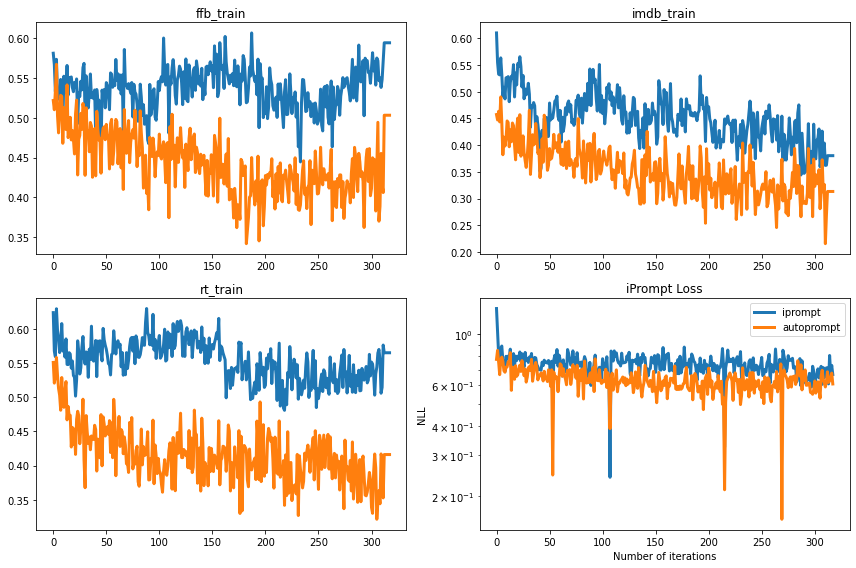

In [116]:
import matplotlib.pyplot as plt
import seaborn as sns

import math

COLORS = sns.color_palette()

BATCH_SIZE = 16
X_AXIS = np.arange(all_losses_padded.shape[1]) 

#############################################

tasks = top_prompts['task_name'].unique()

#############################################
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(12, 8),
                        layout="constrained")

for idx, task in enumerate(tasks):
    for m_idx, model_cls in enumerate(['iprompt', 'autoprompt']):
        MASK = (
              (top_prompts['model_cls'] == model_cls)
            & (top_prompts['task_name'] == task)
            & (top_prompts['num_learned_tokens'] < 24)
        )
        
        i = idx // 2
        j = idx % 2
        
        axs[i,j].plot(X_AXIS, all_losses_padded[MASK].mean(axis=0), color=COLORS[m_idx], label=model_cls, linewidth=3)
    axs[i,j].set_title(task)


#############################################

plt.title('iPrompt Loss')
plt.xlabel('Number of iterations')
plt.ylabel('NLL')
plt.legend()
plt.yscale('log')


pdf_filename = 'sentiment_loss_curves.pdf'
plt.tight_layout()
plt.savefig(pdf_filename, dpi=300)